In [2]:
import os
import PIL
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib, os, random
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions



from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input,Flatten, Dropout,GlobalMaxPooling2D,Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
!git clone https://github.com/RAlfin25/Capstone-BANGKIT-ML-Path.git
%ls

fatal: destination path 'Capstone-BANGKIT-ML-Path' already exists and is not an empty directory.
Capstone-BANGKIT-ML-Path/  sample_data/


In [7]:
# Read image folders (train, test, validation)
train = "/content/Capstone-BANGKIT-ML-Path/FishImgDataset/train"
test = "/content/Capstone-BANGKIT-ML-Path/FishImgDataset/test"
validation = "/content/Capstone-BANGKIT-ML-Path/FishImgDataset/val"

In [8]:
#DATA AUGMENTATION
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
valid_datagen = ImageDataGenerator(rescale = 1.0/255.)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [9]:
train_generator = train_datagen.flow_from_directory(train, target_size=(224,224),batch_size=32,class_mode='categorical')
validation_generator = valid_datagen.flow_from_directory(validation, target_size=(224,224),batch_size=32,class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test, target_size=(224,224),batch_size=32,class_mode='categorical',shuffle=False)

Found 8791 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
Found 1760 images belonging to 31 classes.


In [10]:
#Load Model
inception = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False,input_shape=(224,224,3))
#inception.summary()

87910968/87910968 [==============================] - 1s 0us/step


In [11]:
inception.trainable = True
for layer in inception.layers[:197]:
    layer.trainable = False

In [12]:
for idx, layer in enumerate(inception.layers):
    print(f' {idx}:  {layer.name}: trainable = {layer.trainable}')

 0:  input_1: trainable = False
 1:  conv2d: trainable = False
 2:  batch_normalization: trainable = False
 3:  activation: trainable = False
 4:  conv2d_1: trainable = False
 5:  batch_normalization_1: trainable = False
 6:  activation_1: trainable = False
 7:  conv2d_2: trainable = False
 8:  batch_normalization_2: trainable = False
 9:  activation_2: trainable = False
 10:  max_pooling2d: trainable = False
 11:  conv2d_3: trainable = False
 12:  batch_normalization_3: trainable = False
 13:  activation_3: trainable = False
 14:  conv2d_4: trainable = False
 15:  batch_normalization_4: trainable = False
 16:  activation_4: trainable = False
 17:  max_pooling2d_1: trainable = False
 18:  conv2d_8: trainable = False
 19:  batch_normalization_8: trainable = False
 20:  activation_8: trainable = False
 21:  conv2d_6: trainable = False
 22:  conv2d_9: trainable = False
 23:  batch_normalization_6: trainable = False
 24:  batch_normalization_9: trainable = False
 25:  activation_6: trainab

In [13]:
#get the last layer
last_layer = inception.get_layer('mixed7')

print('last layer output shape: ', last_layer.output_shape)

layer_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


In [15]:
n_categories = len(os.listdir('..//content/Capstone-BANGKIT-ML-Path/FishImgDataset/train'))# number of categories
print(n_categories)

31


In [16]:
# x  = BatchNormalization()(layer_output)
xs = Flatten()(layer_output)
xs = Dense(1024,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001))(xs)
xs = Dropout(0.4)(xs)
xs = Dense(n_categories, activation='softmax')(xs)

model = Model(inputs=inception.inputs, outputs=xs)

In [17]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [18]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [19]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 10, #10
            callbacks=[callback])

Epoch 1/10
275/275 [==============================] - 2370s 9s/step - loss: 3.0585 - accuracy: 0.6710 - val_loss: 1.9713 - val_accuracy: 0.9095 - lr: 1.0000e-04
Epoch 2/10
275/275 [==============================] - 2345s 9s/step - loss: 1.8597 - accuracy: 0.8916 - val_loss: 1.4653 - val_accuracy: 0.9640 - lr: 1.0000e-04
Epoch 3/10
275/275 [==============================] - 2372s 9s/step - loss: 1.3977 - accuracy: 0.9407 - val_loss: 1.1469 - val_accuracy: 0.9782 - lr: 1.0000e-04
Epoch 4/10
275/275 [==============================] - 2329s 8s/step - loss: 1.0907 - accuracy: 0.9594 - val_loss: 0.9311 - val_accuracy: 0.9796 - lr: 1.0000e-04
Epoch 5/10
275/275 [==============================] - 2325s 8s/step - loss: 0.8562 - accuracy: 0.9708 - val_loss: 0.7423 - val_accuracy: 0.9858 - lr: 1.0000e-04
Epoch 6/10
275/275 [==============================] - 2373s 9s/step - loss: 0.6811 - accuracy: 0.9746 - val_loss: 0.5916 - val_accuracy: 0.9876 - lr: 1.0000e-04
Epoch 7/10
275/275 [==============

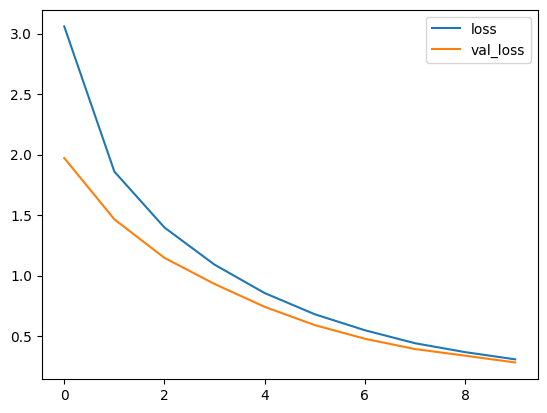

In [20]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

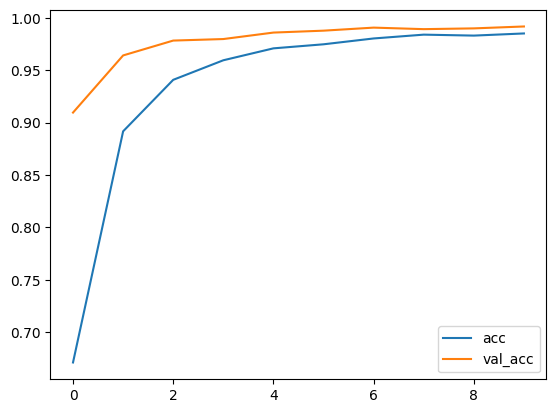

In [21]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

In [22]:
results = model.evaluate(test_generator, verbose=0)


print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.33208
Test Accuracy: 98.18%
